In [134]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [135]:
df1 = pd.read_csv('CMO_MSP_Mandi.csv')

In [136]:
df2 = pd.read_csv('Monthly_data_cmo.csv')

# Fill out missing msprice values for every commodity by averaging their msprice throughtout the years

In [137]:
# filling missing msprice since only this column has na values
missing_msprices = list(np.where(df1['msprice'].isna())[0])
for i in missing_msprices:
    x = list(df1.loc[i])
    commodity = x[0]
    # now take average msprice for the commodity over the years
    avg = np.mean(df1[(df1.commodity == commodity)]['msprice'])
    df1.loc[i, 'msprice'] = avg

In [138]:
# missing values in df2
pd.isnull(df2).any(1).nonzero()[0]  # no missing data in df2

array([], dtype=int32)

# Uppercase evry string in rows of both the dataframe

In [139]:
df1 = df1.rename(columns={'commodity':'Commodity', 'year':'Year'})
def func(x):
    if type(x) == str:
        return x.upper()
    return x
for i in df1.columns:
    df1[i] = df1[i].apply(func)
for i in df2.columns:
    df2[i] = df2[i].apply(func)

# Since 2014-2016 data is available in monthly_mandi_cmo, remove data before 2014 form cmo_msp_mandi

In [140]:
df1 = df1[df1.Year >= 2014]
df1.reset_index(inplace=True, drop=True)

In [141]:
df2['ms_price'] = np.nan

# Adding msprice column to df2 and filling available values from df1

In [142]:
# adding msprice to df2 from df1
for i in range(len(df1)):
    row = dict(df1.iloc[i])
    df2.loc[(df2['Commodity'] == row['Commodity']) & (df2['Year'] == row['Year']),'ms_price'] = row['msprice']

# For commodities with not available ms_price, we will use ml model. Although some or all of these commodities may not have and actual ms_price provided by government.

In [143]:
df3 = df2[['arrivals_in_qtl','min_price','max_price','modal_price','ms_price']].dropna()

In [144]:
y = df3.ms_price
X = df3.drop(columns='ms_price')

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [146]:
df3.corr()

,arrivals_in_qtl,min_price,max_price,modal_price,ms_price
arrivals_in_qtl,1.000000,0.003285,0.078991,0.056665,0.013120
min_price,0.003285,1.000000,0.096212,0.093138,0.097184
max_price,0.078991,0.096212,1.000000,0.921125,0.858300
modal_price,0.056665,0.093138,0.921125,1.000000,0.832734
ms_price,0.013120,0.097184,0.858300,0.832734,1.000000


In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=0)
model = RandomForestRegressor().fit(X_train, y_train)

In [148]:
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9344800277706322
0.984909438943203


In [149]:
A = df2.dropna()   # rows with no missing ms_price
B = df2[df2.isnull().any(axis=1)]  # rows with missing ms_price

In [150]:
B['ms_price'] = model.predict(B[['arrivals_in_qtl','min_price','max_price','modal_price']])

c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [151]:
res = A.append(B, sort=False)
res.sort_index(inplace=True)

# we will be filtering outliers for every commodity

In [152]:
commodities = list(set(res.Commodity))
APMCs = list(set(res.APMC))
Dates = list(set(res.date))
dict_commodities = dict(res.Commodity.value_counts())

In [153]:
def detect_outliers(df, features, whisker_width):
    outliers_indices = []
    for col in features:
        # 1st quartile (25%)
        q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        q3 = np.percentile(df[col], 75)
        # interquartile range
        iqr = q3 - q1
        
        # outliers step
        fence = whisker_width * iqr
        
        mean = np.mean(df[col])
        std = np.std(df[col])
        
        x = df[(df[col] < q1 - fence) | (df[col] > q3 + fence)].index.values
#         x = df[(df[col] < mean - whisker_width*std) | (df[col] > mean + whisker_width*std)].index.values
        

        if len(x) != 0:
            outliers_indices.extend(x)
        
    return outliers_indices

In [154]:
features_to_filter = ['arrivals_in_qtl','min_price','max_price','modal_price','ms_price']
total_outliers = []
for i in commodities:
    df = res[res.Commodity == i]    
    total_outliers.extend(detect_outliers(df, features_to_filter, 1.5))

In [155]:
len(total_outliers)

18166

In [156]:
data = res.drop(res.index[total_outliers])

[]

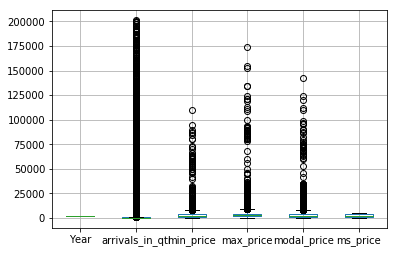

In [157]:
data.boxplot()
plt.plot()

In [158]:
commodities = list(set(res.Commodity))
APMCs = list(set(res.APMC))
Dates = list(set(data.date))
dict_commodities = dict(data.Commodity.value_counts())

# Now on to the seasonality effect

1. Price Fluctuation accounting seasonal effect

lets create 4 seasons year: winter(Dec-Feb), Autumn(Mar-May), Summer(Jun-Aug), Spring(Sep-Nov) and see price fluctuation accounting these seasons. We can consider two seasons Kharif(15 Jun- 15 Oct), Rabi(15 Oct- 15 Feb), and Summer(15 Feb- 15 Jun) as well. For price fluctuataio, get average modal price across the APMCs.

In [159]:
data['Season'] = np.nan

In [160]:
def season(x):
    if x['Month'] in ['JUNE','JULY','AUGUST','SEPTEMBER']:
        return 'KHARIF'
    elif x['Month'] in ['OCTOBER','NOVEMBER','DECEMBER','JANUARY']:
        return 'RABI' 
    else:
        return 'SUMMER' 
data['Season'] = data.apply(season, axis=1)

In [161]:
data.describe()

,Year,arrivals_in_qtl,min_price,max_price,modal_price,ms_price
count,48437.000000,48437.000000,48437.000000,48437.000000,48437.000000,48437.000000
mean,2015.329294,2274.135413,2907.559407,3593.904267,3271.342713,2542.862744
std,0.685126,12315.980043,2929.317290,3918.638672,3391.315887,1330.842883
min,2014.000000,1.000000,0.000000,0.000000,0.000000,230.000000
25%,2015.000000,28.000000,1281.000000,1600.000000,1463.000000,1450.000000
50%,2015.000000,141.000000,1914.000000,2727.000000,2358.000000,1616.125000
75%,2016.000000,622.000000,3938.000000,4584.000000,4250.000000,3912.500000
max,2016.000000,201100.000000,110313.000000,174375.000000,142344.000000,4800.000000


From observaion below, it can be seen that variance in prices for a commodity at a date is not much across the APMCs.

Mean and Standard Deviation for Bajri Modal Prices in October 2015 across various APMC are 1420.82 and 157.23 respectively.
Mean and Standard Deviation for Bajri Modal Prices in October 2015 across various APMC are 1385.69 and 181.77 respectively.


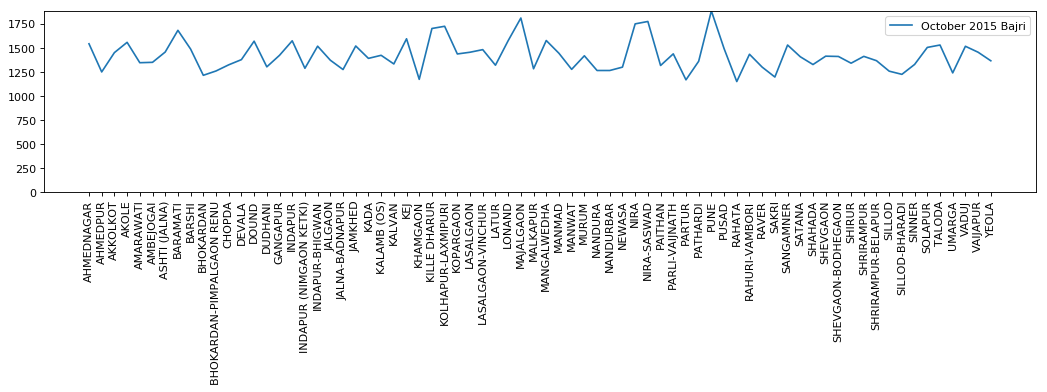

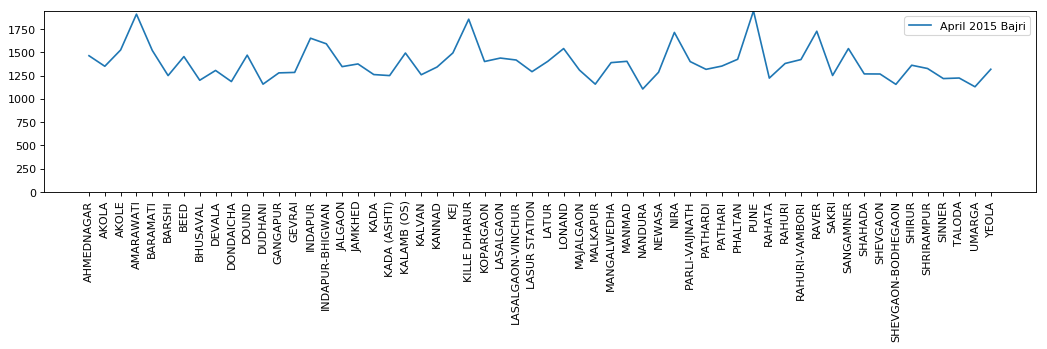

In [162]:
Set1 = data[(data.Commodity == 'BAJRI') & (data.Month == 'OCTOBER') & (data.Year == 2015)].sort_values(by='APMC')
Set2 = data[(data.Commodity == 'BAJRI') & (data.Month == 'APRIL') & (data.Year == 2015)].sort_values(by='APMC')
print('Mean and Standard Deviation for Bajri Modal Prices in October 2015 across various APMC are',round(np.mean(Set1.modal_price),2),'and',round(np.std(Set1.modal_price),2),'respectively.')
print('Mean and Standard Deviation for Bajri Modal Prices in October 2015 across various APMC are',round(np.mean(Set2.modal_price),2),'and',round(np.std(Set2.modal_price),2),'respectively.')
figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
plt.ylim(ymin=0, ymax = max(Set1.modal_price))
plt.plot(Set1.APMC, Set1.modal_price, label='October 2015 Bajri')
plt.legend()
plt.show()
figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
plt.ylim(ymin=0, ymax = max(Set2.modal_price))
plt.plot(Set2.APMC, Set2.modal_price, label='April 2015 Bajri')
plt.legend()
plt.show()

now let's create a mean modal price for each commodity every availble month averaging across ACMP.

In [163]:
a = data.groupby(['Commodity','date'])

In [164]:
b = pd.DataFrame(a.mean()).reset_index()

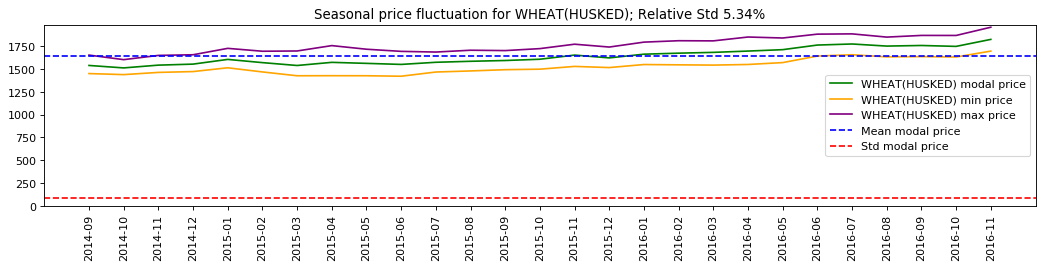

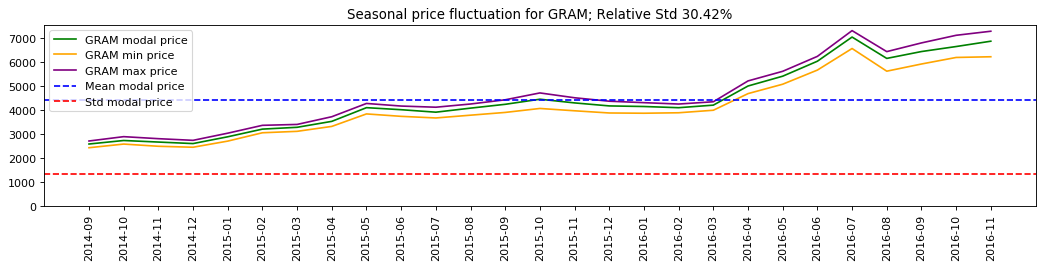

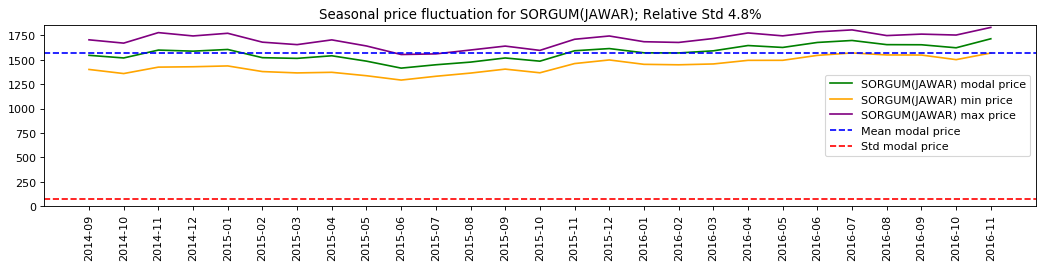

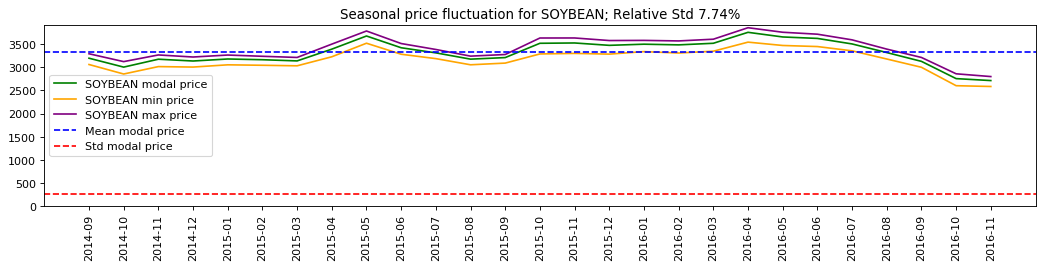

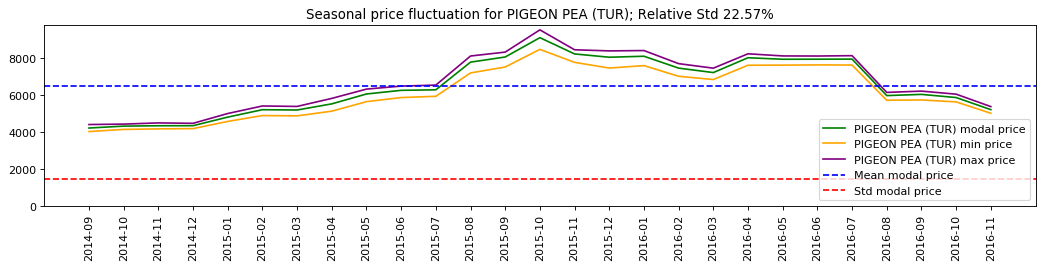

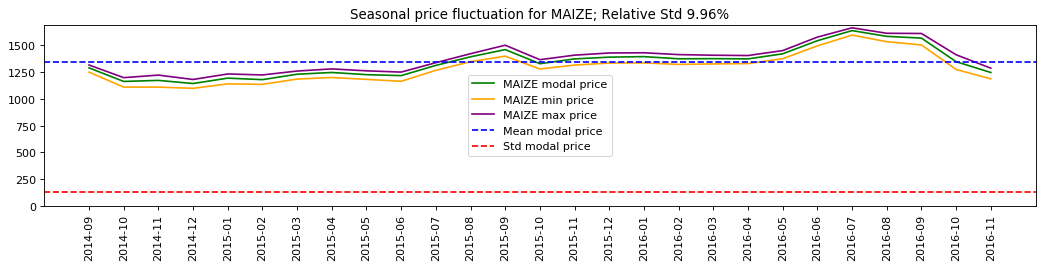

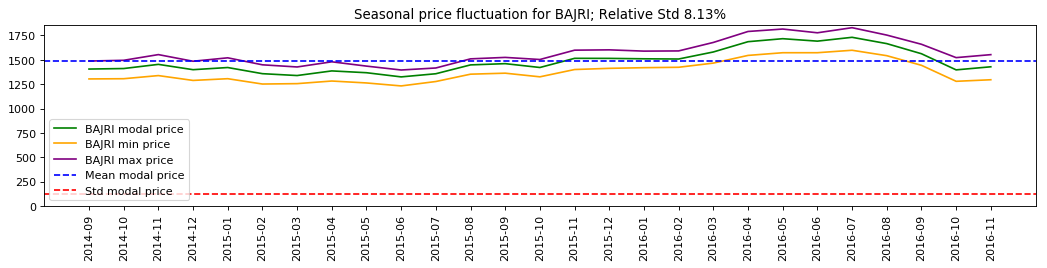

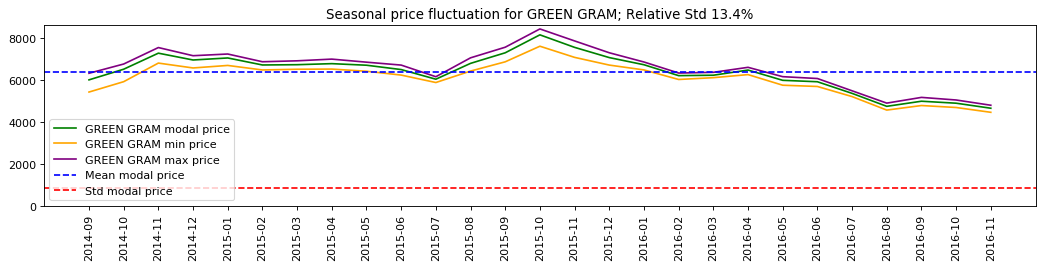

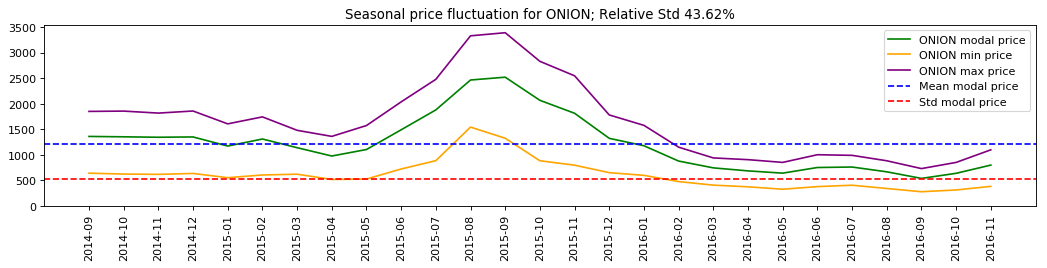

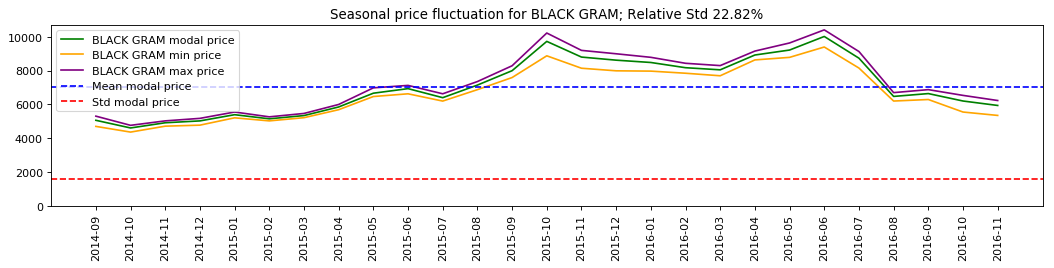

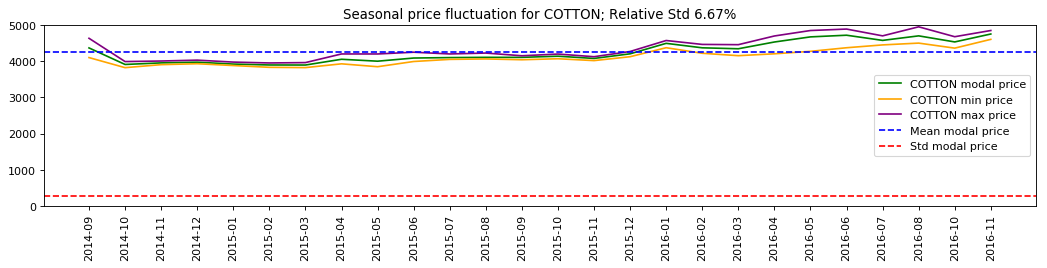

In [165]:
for key, val in dict_commodities.items():   
    x = b[b.Commodity == key]
    figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(rotation=90)
    plt.plot(x.date, x.modal_price, label=key+' modal price', color='green')
    plt.plot(x.date, x.min_price, label=key+' min price', color='orange')
    plt.plot(x.date, x.max_price, label=key+ ' max price', color='purple')
#     plt.plot(x.date, x.ms_price, label=key+ ' ms price', color='maroon')
    plt.ylim(ymin=0)
    plt.axhline(y=np.mean(x.modal_price), color='blue', linestyle='--', label='Mean modal price')
    plt.axhline(y=np.std(x.modal_price), color='red', linestyle='--', label='Std modal price')
    plt.title('Seasonal price fluctuation for '+key + '; Relative Std '+ str(round(np.std(x.modal_price)/np.mean(x.modal_price)*100,2))+'%')
    plt.legend()
    
    if val < 1000:  # because for high value of occurance of a commodity, the more commonly it is used.
        break
plt.show()

From the plot above, price fluctuation can be seen throughtout the year. Commodities with high relative standard deviation are more likely to be have seasonal effect on the modal, min and max prices.

# Seasonality Type

We will use Jalgaon APMC and WHEAT(HUSKED) commodity for detection. Next do it for all clusters of APMCs and Commodities.
Arrival quantity is used for seasonality detection.

In [166]:
X = data.groupby(['Commodity','date'])   # for each commodity, take mean across all the APMCs. change this line accordingly

In [167]:
X = pd.DataFrame(X.mean()).reset_index()

In [168]:
X.head()

,Commodity,date,Year,arrivals_in_qtl,min_price,max_price,modal_price,ms_price
0,AMBA KOY,2016-05,2016.0,90.0,1000.0,2000.0,1500.0,1538.125
1,AMBA KOY,2016-06,2016.0,435.0,3250.0,4250.0,3750.0,3538.125
2,AMBA KOY,2016-07,2016.0,160.0,4125.0,5375.0,4750.0,4400.000
3,AMBAT CHUKA,2014-09,2014.0,8.0,0.0,1650.0,0.0,1711.250
4,AMBAT CHUKA,2014-10,2014.0,27.0,109.0,1255.0,136.0,1558.500


In [169]:
y = X[X.Commodity == 'WHEAT(HUSKED)'].sort_index()

In [170]:
y['date'] = pd.to_datetime(y['date'])

In [171]:
y.set_index('date', inplace=True)
y.sort_index(inplace=True)

In [172]:
y.head()

,Commodity,Year,arrivals_in_qtl,min_price,max_price,modal_price,ms_price
date,,,,,,,
2014-09-01,WHEAT(HUSKED),2014.0,560.396226,1448.330189,1650.566038,1537.122642,1450.0
2014-10-01,WHEAT(HUSKED),2014.0,481.666667,1436.981982,1600.630631,1510.306306,1450.0
2014-11-01,WHEAT(HUSKED),2014.0,494.939655,1461.060345,1647.034483,1540.672414,1450.0
2014-12-01,WHEAT(HUSKED),2014.0,408.793103,1470.241379,1654.206897,1551.750000,1450.0
2015-01-01,WHEAT(HUSKED),2015.0,465.957627,1511.610169,1724.186441,1603.322034,1525.0


In [173]:
import statsmodels.api as sm

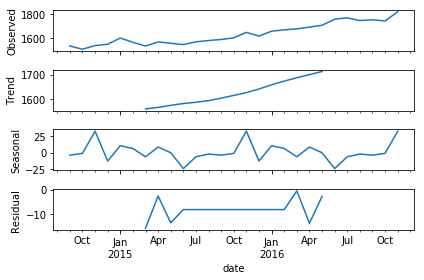

In [174]:
decomposition1 = sm.tsa.seasonal_decompose(y.modal_price,  model='additive')
fig1 = decomposition1.plot()

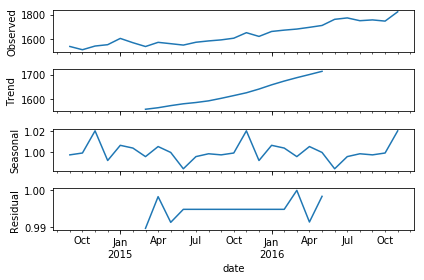

In [175]:
decomposition2 = sm.tsa.seasonal_decompose(y.modal_price,  model='multiplicative')
fig2 = decomposition2.plot()

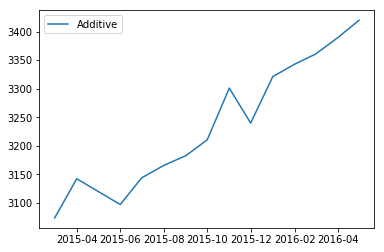

In [176]:
plt.plot(y.index, decomposition1.observed + decomposition1.seasonal + decomposition1.trend + decomposition1.resid, label='Additive')
plt.legend()

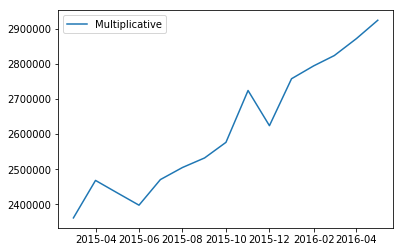

In [177]:
plt.plot(y.index, decomposition2.observed * decomposition2.seasonal * decomposition2.trend * decomposition2.resid, label='Multiplicative')
plt.legend()

In [178]:
y['Trend'] = y['modal_price'].rolling(30).mean()  # trend calculation
y.dropna(inplace=True)

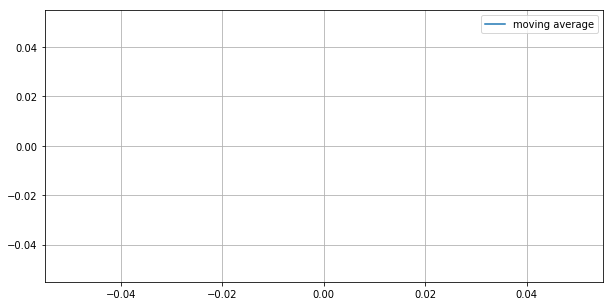

In [179]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(y.Trend, label='moving average')
plt.legend()
plt.show()

# Deseasonalize data Arrival Quantity

In [229]:
des_df = data.copy(deep=True)

In [230]:
des_df['date'] = pd.to_datetime(des_df.date)

In [231]:
des_df = des_df.set_index('date')

In [232]:
des_df['quarter'] = des_df.index.quarter

In [233]:
des_df['trend'] = des_df.arrivals_in_qtl.rolling(30).mean()  

In [234]:
des_df.dropna(inplace=True)

In [235]:
des_df['additive_detrend'] = des_df.arrivals_in_qtl - des_df.trend
des_df['multiplicative_detrend'] = des_df.arrivals_in_qtl / des_df.trend

In [236]:
# additive quarter mean
add_qm = list(des_df.groupby('quarter').additive_detrend.mean())
# multiplicative quarter mean
multi_qm = list(des_df.groupby('quarter').multiplicative_detrend.mean())

In [237]:
def seasonal_func(x, qm):
        return qm[int(x['quarter'])-1]
des_df['additive_seasonal'] = des_df.apply(seasonal_func, qm=add_qm, axis=1)
des_df['multiplicative_seasonal'] = des_df.apply(seasonal_func, qm=multi_qm, axis=1)

In [238]:
des_df['additive_residual'] = des_df.additive_detrend - des_df.additive_seasonal
des_df['multiplicative_residual'] = des_df.multiplicative_detrend - des_df.multiplicative_seasonal

In [239]:
def detect_seasonality_type(add,mult):
    if add.autocorr()**2 < mult.autocorr()**2:
        return 'Additive'
    else:
        return 'Multiplicative'

In [240]:
des_df['seasonality_type'] = np.nan
for i in des_df.Commodity.unique():
    x = detect_seasonality_type(des_df.loc[des_df.Commodity == i, 'additive_residual'], des_df.loc[des_df.Commodity == i, 'multiplicative_residual'])
    des_df.loc[des_df.Commodity == i, 'seasonality_type'] = x

c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [241]:
des_df['Deseasonlized_arriaval_quantity'] = des_df.arrivals_in_qtl / des_df.multiplicative_seasonal

# Deseasonalize data Modal Price

In [242]:
des_df['trend'] = des_df.modal_price.rolling(30).mean()  

In [243]:
des_df.dropna(inplace=True)

In [244]:
des_df['additive_detrend'] = des_df.modal_price - des_df.trend
des_df['multiplicative_detrend'] = des_df.modal_price / des_df.trend

In [245]:
# additive quarter mean
add_qm = list(des_df.groupby('quarter').additive_detrend.mean())
# multiplicative quarter mean
multi_qm = list(des_df.groupby('quarter').multiplicative_detrend.mean())

In [246]:
def seasonal_func(x, qm):
        return qm[int(x['quarter'])-1]
des_df['additive_seasonal'] = des_df.apply(seasonal_func, qm=add_qm, axis=1)
des_df['multiplicative_seasonal'] = des_df.apply(seasonal_func, qm=multi_qm, axis=1)

In [247]:
des_df['additive_residual'] = des_df.additive_detrend - des_df.additive_seasonal
des_df['multiplicative_residual'] = des_df.multiplicative_detrend - des_df.multiplicative_seasonal

In [248]:
def detect_seasonality_type(add,mult):
    if add.autocorr()**2 < mult.autocorr()**2:
        return 'Additive'
    else:
        return 'Multiplicative'

In [249]:
des_df['seasonality_type'] = np.nan
for i in des_df.Commodity.unique():
    x = detect_seasonality_type(des_df.loc[des_df.Commodity == i, 'additive_residual'], des_df.loc[des_df.Commodity == i, 'multiplicative_residual'])
    des_df.loc[des_df.Commodity == i, 'seasonality_type'] = x

c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [250]:
des_df['Deseasonlized_modal_price'] = des_df.modal_price / des_df.multiplicative_seasonal


# Deseasonalize data Minimum Price

In [251]:
des_df['trend'] = des_df.min_price.rolling(30).mean()  

In [252]:
des_df.dropna(inplace=True)

In [253]:
des_df['additive_detrend'] = des_df.min_price - des_df.trend
des_df['multiplicative_detrend'] = des_df.min_price / des_df.trend

In [254]:
# additive quarter mean
add_qm = list(des_df.groupby('quarter').additive_detrend.mean())
# multiplicative quarter mean
multi_qm = list(des_df.groupby('quarter').multiplicative_detrend.mean())

In [255]:
def seasonal_func(x, qm):
        return qm[int(x['quarter'])-1]
des_df['additive_seasonal'] = des_df.apply(seasonal_func, qm=add_qm, axis=1)
des_df['multiplicative_seasonal'] = des_df.apply(seasonal_func, qm=multi_qm, axis=1)

In [256]:
des_df['additive_residual'] = des_df.additive_detrend - des_df.additive_seasonal
des_df['multiplicative_residual'] = des_df.multiplicative_detrend - des_df.multiplicative_seasonal

In [257]:
def detect_seasonality_type(add,mult):
    if add.autocorr()**2 < mult.autocorr()**2:
        return 'Additive'
    else:
        return 'Multiplicative'

In [258]:
des_df['seasonality_type'] = np.nan
for i in des_df.Commodity.unique():
    x = detect_seasonality_type(des_df.loc[des_df.Commodity == i, 'additive_residual'], des_df.loc[des_df.Commodity == i, 'multiplicative_residual'])
    des_df.loc[des_df.Commodity == i, 'seasonality_type'] = x

c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [259]:
des_df['Deseasonlized_min_price'] = des_df.min_price / des_df.multiplicative_seasonal


# Deseasonalize data Maximum Price

In [260]:
des_df['trend'] = des_df.max_price.rolling(30).mean()  

In [261]:
des_df.dropna(inplace=True)

In [262]:
des_df['additive_detrend'] = des_df.max_price - des_df.trend
des_df['multiplicative_detrend'] = des_df.max_price / des_df.trend

In [263]:
# additive quarter mean
add_qm = list(des_df.groupby('quarter').additive_detrend.mean())
# multiplicative quarter mean
multi_qm = list(des_df.groupby('quarter').multiplicative_detrend.mean())

In [264]:
def seasonal_func(x, qm):
        return qm[int(x['quarter'])-1]
des_df['additive_seasonal'] = des_df.apply(seasonal_func, qm=add_qm, axis=1)
des_df['multiplicative_seasonal'] = des_df.apply(seasonal_func, qm=multi_qm, axis=1)

In [265]:
des_df['additive_residual'] = des_df.additive_detrend - des_df.additive_seasonal
des_df['multiplicative_residual'] = des_df.multiplicative_detrend - des_df.multiplicative_seasonal

In [266]:
def detect_seasonality_type(add,mult):
    if add.autocorr()**2 < mult.autocorr()**2:
        return 'Additive'
    else:
        return 'Multiplicative'

In [267]:
des_df['seasonality_type'] = np.nan
for i in des_df.Commodity.unique():
    x = detect_seasonality_type(des_df.loc[des_df.Commodity == i, 'additive_residual'], des_df.loc[des_df.Commodity == i, 'multiplicative_residual'])
    des_df.loc[des_df.Commodity == i, 'seasonality_type'] = x

c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [277]:
des_df['Deseasonlized_max_price'] = des_df.max_price / des_df.multiplicative_seasonal

In [278]:
des_df.head(5)

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,district_name,state_name,...,additive_seasonal,multiplicative_seasonal,additive_residual,multiplicative_residual,seasonality_type,Deseasonlized_arriaval_quantity,Deseasonlized_modal_price,Deseasonlized_min_price,Deseasonlized_maximum_price,Deseasonlized_max_price
date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,RAHATA,SOYBEAN,2016,APRIL,35,3879,3902,3882,AHMADNAGAR,MAHARASHTRA,...,33.262801,1.023992,1371.803866,0.538725,Multiplicative,32.072624,3776.828925,3742.145624,3810.578270,3810.578270
2015-04-01,RAHATA,GINGER (FRESH),2015,APRIL,31,3125,3417,3242,AHMADNAGAR,MAHARASHTRA,...,33.262801,1.023992,932.337199,0.369906,Multiplicative,28.407181,3154.167793,3014.747377,3336.941555,3336.941555
2016-04-01,RAHATA,GINGER (FRESH),2016,APRIL,39,1550,2167,1792,AHMADNAGAR,MAHARASHTRA,...,33.262801,1.023992,-349.062801,-0.151187,Multiplicative,35.738066,1743.451168,1495.314699,2116.228373,2116.228373
2015-04-01,RAHATA,POTATO,2015,APRIL,1467,588,1346,696,AHMADNAGAR,MAHARASHTRA,...,33.262801,1.023992,-1136.596134,-0.474454,Multiplicative,1344.301107,677.143980,567.254866,1314.463955,1314.463955
2016-04-01,RAHATA,POTATO,2016,APRIL,851,1192,1542,1392,AHMADNAGAR,MAHARASHTRA,...,33.262801,1.023992,-947.262801,-0.396141,Multiplicative,779.822932,1354.287961,1149.945239,1505.871782,1505.871782


In [279]:
cols_to_keep = ['APMC', 'Commodity', 'Year', 'Month', 'arrivals_in_qtl', 'min_price',
       'max_price', 'modal_price', 'district_name', 'state_name', 'ms_price',
       'Season', 'quarter', 'Deseasonlized_arriaval_quantity', 'Deseasonlized_modal_price',
       'Deseasonlized_min_price', 'Deseasonlized_max_price']

In [280]:
deseasonalized_data = des_df[cols_to_keep]

In [281]:
deseasonalized_data.head(5)

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,district_name,state_name,ms_price,Season,quarter,Deseasonlized_arriaval_quantity,Deseasonlized_modal_price,Deseasonlized_min_price,Deseasonlized_max_price
date,,,,,,,,,,,,,,,,,
2016-04-01,RAHATA,SOYBEAN,2016,APRIL,35,3879,3902,3882,AHMADNAGAR,MAHARASHTRA,3447.000,SUMMER,2,32.072624,3776.828925,3742.145624,3810.578270
2015-04-01,RAHATA,GINGER (FRESH),2015,APRIL,31,3125,3417,3242,AHMADNAGAR,MAHARASHTRA,3622.500,SUMMER,2,28.407181,3154.167793,3014.747377,3336.941555
2016-04-01,RAHATA,GINGER (FRESH),2016,APRIL,39,1550,2167,1792,AHMADNAGAR,MAHARASHTRA,1554.125,SUMMER,2,35.738066,1743.451168,1495.314699,2116.228373
2015-04-01,RAHATA,POTATO,2015,APRIL,1467,588,1346,696,AHMADNAGAR,MAHARASHTRA,1372.500,SUMMER,2,1344.301107,677.143980,567.254866,1314.463955
2016-04-01,RAHATA,POTATO,2016,APRIL,851,1192,1542,1392,AHMADNAGAR,MAHARASHTRA,1402.500,SUMMER,2,779.822932,1354.287961,1149.945239,1505.871782


Comapring msprice vs prices for different commodities and APMCs

In [282]:
deseasonalized_data.APMC.value_counts()[:5]  # take Jalgaon APMC

JALGAON        943
SHRIRAMPUR     875
BARSHI         805
PUNE-MANJRI    787
KAMTHI         774
Name: APMC, dtype: int64

In [283]:
deseasonalized_data.Commodity.value_counts()[:5]  # take Wheat(Husked)

WHEAT(HUSKED)       3342
GRAM                3135
SORGUM(JAWAR)       3124
SOYBEAN             3040
PIGEON PEA (TUR)    2909
Name: Commodity, dtype: int64

# Comparing Prices with Price

In [312]:
X = deseasonalized_data.groupby('Commodity').mean().reset_index()

In [316]:
to_plot = X.sort_values(by='arrivals_in_qtl', ascending=False)[:10]

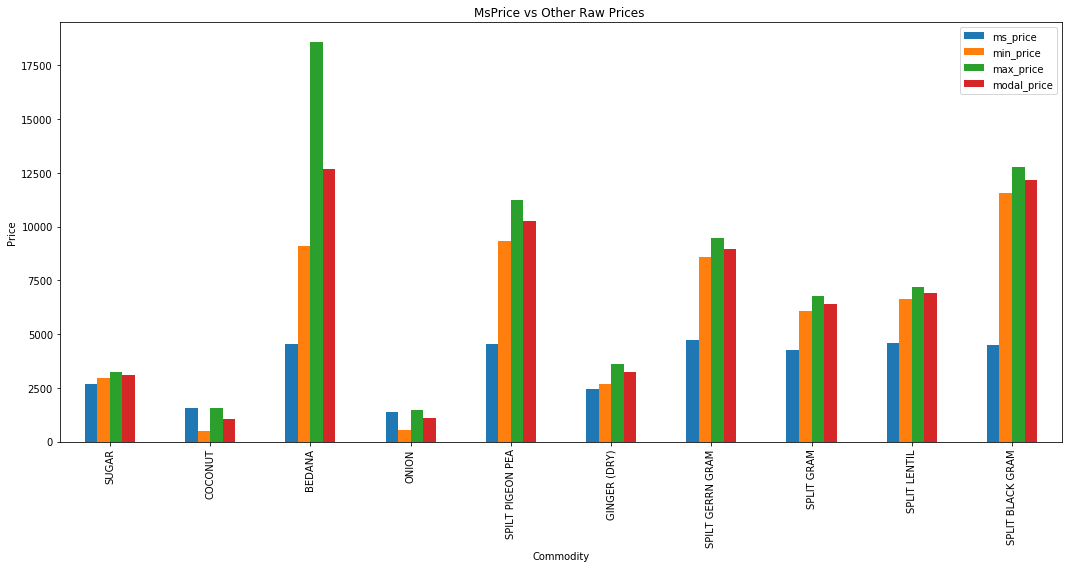

<Figure size 720x360 with 0 Axes>

In [319]:
fig, ax = plt.subplots(figsize=(15,8))
ax = to_plot.plot(x='Commodity', y=['ms_price', 'min_price','max_price', 'modal_price'], kind='bar', ax=ax)
plt.figure(figsize=(10,5))
ax.set_ylabel('Price')
ax.set_xlabel('Commodity')
ax.set_title('MsPrice vs Other Raw Prices ')
fig.tight_layout()
plt.show()

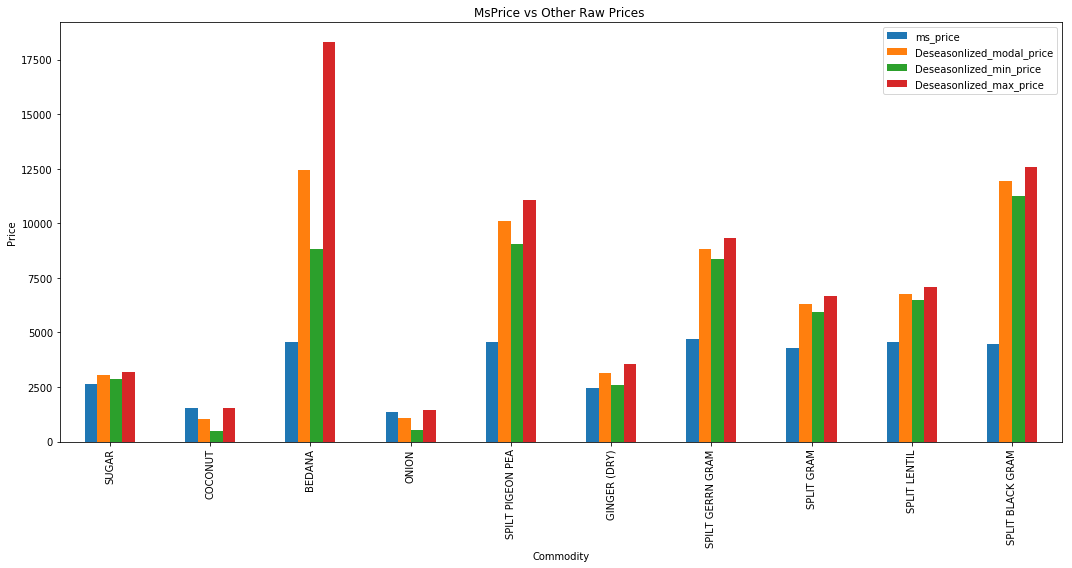

<Figure size 720x360 with 0 Axes>

In [318]:
fig, ax = plt.subplots(figsize=(15,8))
ax = to_plot.plot(x='Commodity', y=['ms_price', 'Deseasonlized_modal_price', 'Deseasonlized_min_price', 'Deseasonlized_max_price'], kind='bar', ax=ax)
plt.figure(figsize=(10,5))
ax.set_ylabel('Price')
ax.set_xlabel('Commodity')
ax.set_title('MsPrice vs Other Raw Prices ')
fig.tight_layout()
plt.show()

# Price Fluctuation For Different APMCs

In [326]:
deseasonalized_data['price_fluctuation_deseaconalized'] = deseasonalized_data.Deseasonlized_max_price - deseasonalized_data.Deseasonlized_min_price
deseasonalized_data['price_fluctuation'] = deseasonalized_data.max_price - deseasonalized_data.min_price

c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\anurag gupta\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [350]:
for_price_fluct = deseasonalized_data.sort_values(by='price_fluctuation_deseaconalized', ascending=False)

In [351]:
for_price_fluct = for_price_fluct.groupby(['APMC', 'Year']).mean().reset_index()

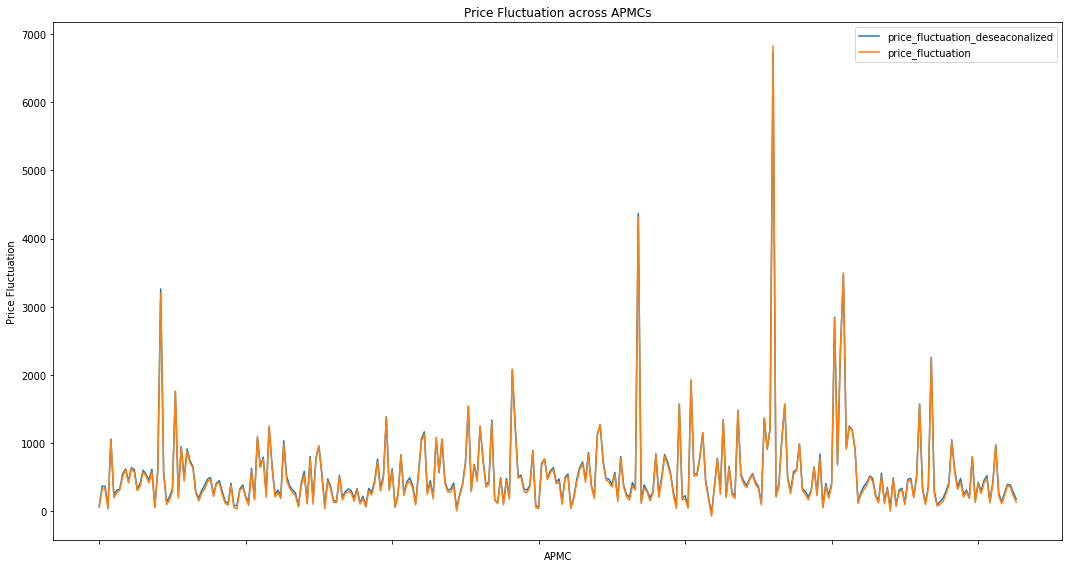

<Figure size 720x360 with 0 Axes>

In [353]:
fig, ax = plt.subplots(figsize=(15,8))
plt.figure(figsize=(10,5))
ax = for_price_fluct[for_price_fluct['Year'] == 2015].plot(x='APMC', y=['price_fluctuation_deseaconalized','price_fluctuation'], ax= ax)
ax.set_ylabel('Price Fluctuation')
ax.set_title('Price Fluctuation across APMCs')
fig.tight_layout()
plt.show()

In [363]:
for_price_fluct.sort_values(by='price_fluctuation_deseaconalized', ascending=False)[['APMC','price_fluctuation_deseaconalized']].head(10)

,APMC,price_fluctuation_deseaconalized
344,JUNNAR (BHLHE),17680.213249
679,PIMPALGAON BASAWANT,7200.678435
678,PIMPALGAON BASAWANT,6729.206252
373,KALYAN (CATTLE MARKET),5384.577577
677,PIMPALGAON BASAWANT,5309.506305
753,SANGOLA,4733.442581
542,MUMBAI,4368.864112
751,SANGOLA,4081.330754
543,MUMBAI,4065.078324
239,GADHINGLAJ,3848.467669
